In [1]:
from PIL import Image
from pathlib import Path
import math
import torch
import torchvision as tv
import torchvision.transforms.functional as tvf
torch.set_grad_enabled(False)

from lvae import get_model

d:\libraries\anaconda3\envs\pt113env\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device('cuda:0')

# initialize model
model = get_model('qres34m', lmb=2048, pretrained=True)

model.eval()
model = model.to(device=device)

In [3]:
impath = Path('../../images/collie128.png')
im = im = tvf.to_tensor(Image.open(impath)).unsqueeze_(0).to(device=device)
nB, imC, imH, imW = im.shape

stats_all = model.forward_get_latents(im)

progressive_decodings = []
L = len(stats_all)
for keep in range(1, L+1):
    latents = [stat['z'] if (i < keep) else None for (i,stat) in enumerate(stats_all)]
    kl_divs = [stat['kl'] for (i,stat) in enumerate(stats_all) if (i < keep)]
    kl = sum([kl.sum(dim=(1,2,3)) for kl in kl_divs]) / (imH * imW) * math.log2(math.e)
    sample = model.cond_sample(latents, temprature=0)
    progressive_decodings.append(sample.squeeze(0))
    print(f'Keep={keep}, bpp={kl.item()}')
progressive_decodings = torch.stack(progressive_decodings, dim=0)

Keep=1, bpp=0.010392916388809681
Keep=2, bpp=0.04204000160098076
Keep=3, bpp=0.07201889157295227
Keep=4, bpp=0.22939209640026093
Keep=5, bpp=0.36846473813056946
Keep=6, bpp=0.5077057480812073
Keep=7, bpp=1.1556090116500854
Keep=8, bpp=1.6932148933410645
Keep=9, bpp=2.0942583084106445
Keep=10, bpp=3.4298152923583984
Keep=11, bpp=4.987067222595215
Keep=12, bpp=5.490642547607422


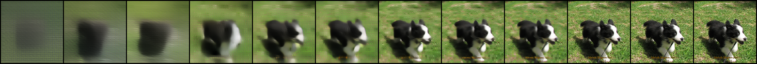

In [4]:
im = tv.utils.make_grid(progressive_decodings, nrow=12)
tvf.resize(tvf.to_pil_image(im), 64)